In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import glob
import os
from IPython.display import Image, display

import torch
import cv2

from google.colab import files

In [ ]:
#download the data
import kagglehub

%mkdir kaggle
kagglehub.dataset_download("saumyapatel/traffic-vehicles-object-detection")
%cp "/root/.cache/kagglehub/datasets/saumyapatel/traffic-vehicles-object-detection/versions/1/Traffic Dataset" /content/kaggle/ -a

100%|██████████| 607M/607M [00:09<00:00, 66.1MB/s]

Extracting files...


In [ ]:
#we use yolov5 pretrained model for this project
!git clone https://github.com/ultralytics/yolov5
%cd /content/yolov5/

#install the dependencies
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17067, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 17067 (delta 24), reused 28 (delta 12), pack-reused 17022 (from 1)
Receiving objects: 100% (17067/17067), 15.68 MiB | 17.07 MiB/s, done.
Resolving deltas: 100% (11719/11719), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.9/896.9 kB 18.3 MB/s eta 0:00:00


In [ ]:
#create the dataset with train and validate data
yaml_content = """
train: /content/kaggle/Traffic Dataset/images/train
val: /content/kaggle/Traffic Dataset/images/val

nc: 7
names: ['Car', 'Number Plate', 'Blur Number Plate', 'Two Wheeler', 'Auto', 'Bus', 'Truck']
"""

yaml_path = '/content/yolov5/dataset.yaml'

with open(yaml_path, 'w') as file:
    file.write(yaml_content)

In [ ]:
#train the model with our custom data
%cd /content/yolov5/
!python train.py --img 640 --batch 16 --epochs 20 --data dataset.yaml --weights yolov5s.pt --cache

/content/yolov5
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-01 20:31:34.413101: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-01 20:31:34.443011: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-01 20:31:34.448872: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452

In [ ]:
#save the trained weights
!cd /content/
dir_to_zip = '/content/yolov5/' #@param {type: "string"}
output_filename = 'yolov5.zip' #@param {type: "string"}
delete_dir_after_download = "No"  #@param ['Yes', 'No']

os.system( "zip -r {} {}".format( output_filename , dir_to_zip ) )

if delete_dir_after_download == "Yes":
    os.system( "rm -r {}".format( dir_to_zip ) )

files.download( output_filename )

#load the trained weights to the current directory
%cd /content
!unzip yolov5.zip -d /content
%cd /content/yolov5/

!rm -r /content/yolov5

/content
Archive:  yolov5.zip
   creating: /content/yolov5/
  inflating: /content/yolov5/.dockerignore  
   creating: /content/yolov5/.git/
   creating: /content/yolov5/.git/branches/
  inflating: /content/yolov5/.git/config  
  inflating: /content/yolov5/.git/description  
  inflating: /content/yolov5/.git/FETCH_HEAD  
 extracting: /content/yolov5/.git/HEAD  
   creating: /content/yolov5/.git/hooks/
  inflating: /content/yolov5/.git/hooks/applypatch-msg.sample  
  inflating: /content/yolov5/.git/hooks/commit-msg.sample  
  inflating: /content/yolov5/.git/hooks/fsmonitor-watchman.sample  
  inflating: /content/yolov5/.git/hooks/post-update.sample  
  inflating: /content/yolov5/.git/hooks/pre-applypatch.sample  
  inflating: /content/yolov5/.git/hooks/pre-commit.sample  
  inflating: /content/yolov5/.git/hooks/pre-merge-commit.sample  
  inflating: /content/yolov5/.git/hooks/pre-push.sample  
  inflating: /content/yolov5/.git/hooks/pre-rebase.sample  
  inflating: /content/yolov5/.git/h

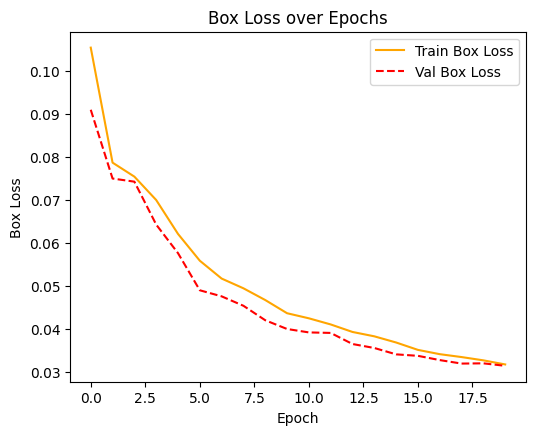

In [ ]:
#Model Result Visualization
data = pd.read_csv('runs/train/exp/results.csv')
plt.figure(figsize=(20, 10))
plt.subplot(2, 3, 2)
plt.plot(data['               epoch'], data['      train/box_loss'], label='Train Box Loss', color='orange')
plt.plot(data['               epoch'], data['        val/box_loss'], label='Val Box Loss', linestyle='--', color='red')
plt.xlabel('Epoch')
plt.ylabel('Box Loss')
plt.title('Box Loss over Epochs')
plt.legend()
plt.show()

In [ ]:
#evaluating the model
!python val.py --img 640 --data dataset.yaml --weights runs/train/exp/weights/best.pt

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
val: data=dataset.yaml, weights=['runs/train/exp/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
100% 755k/755k [00:00<00:00, 3.80MB/s]
val: Scanning /content/kaggle/Traffic Dataset/labels/val... 185 images, 1 backgrounds, 0 corrupt: 100% 185/185 [00:00<00:00, 962.71it/s]
val:

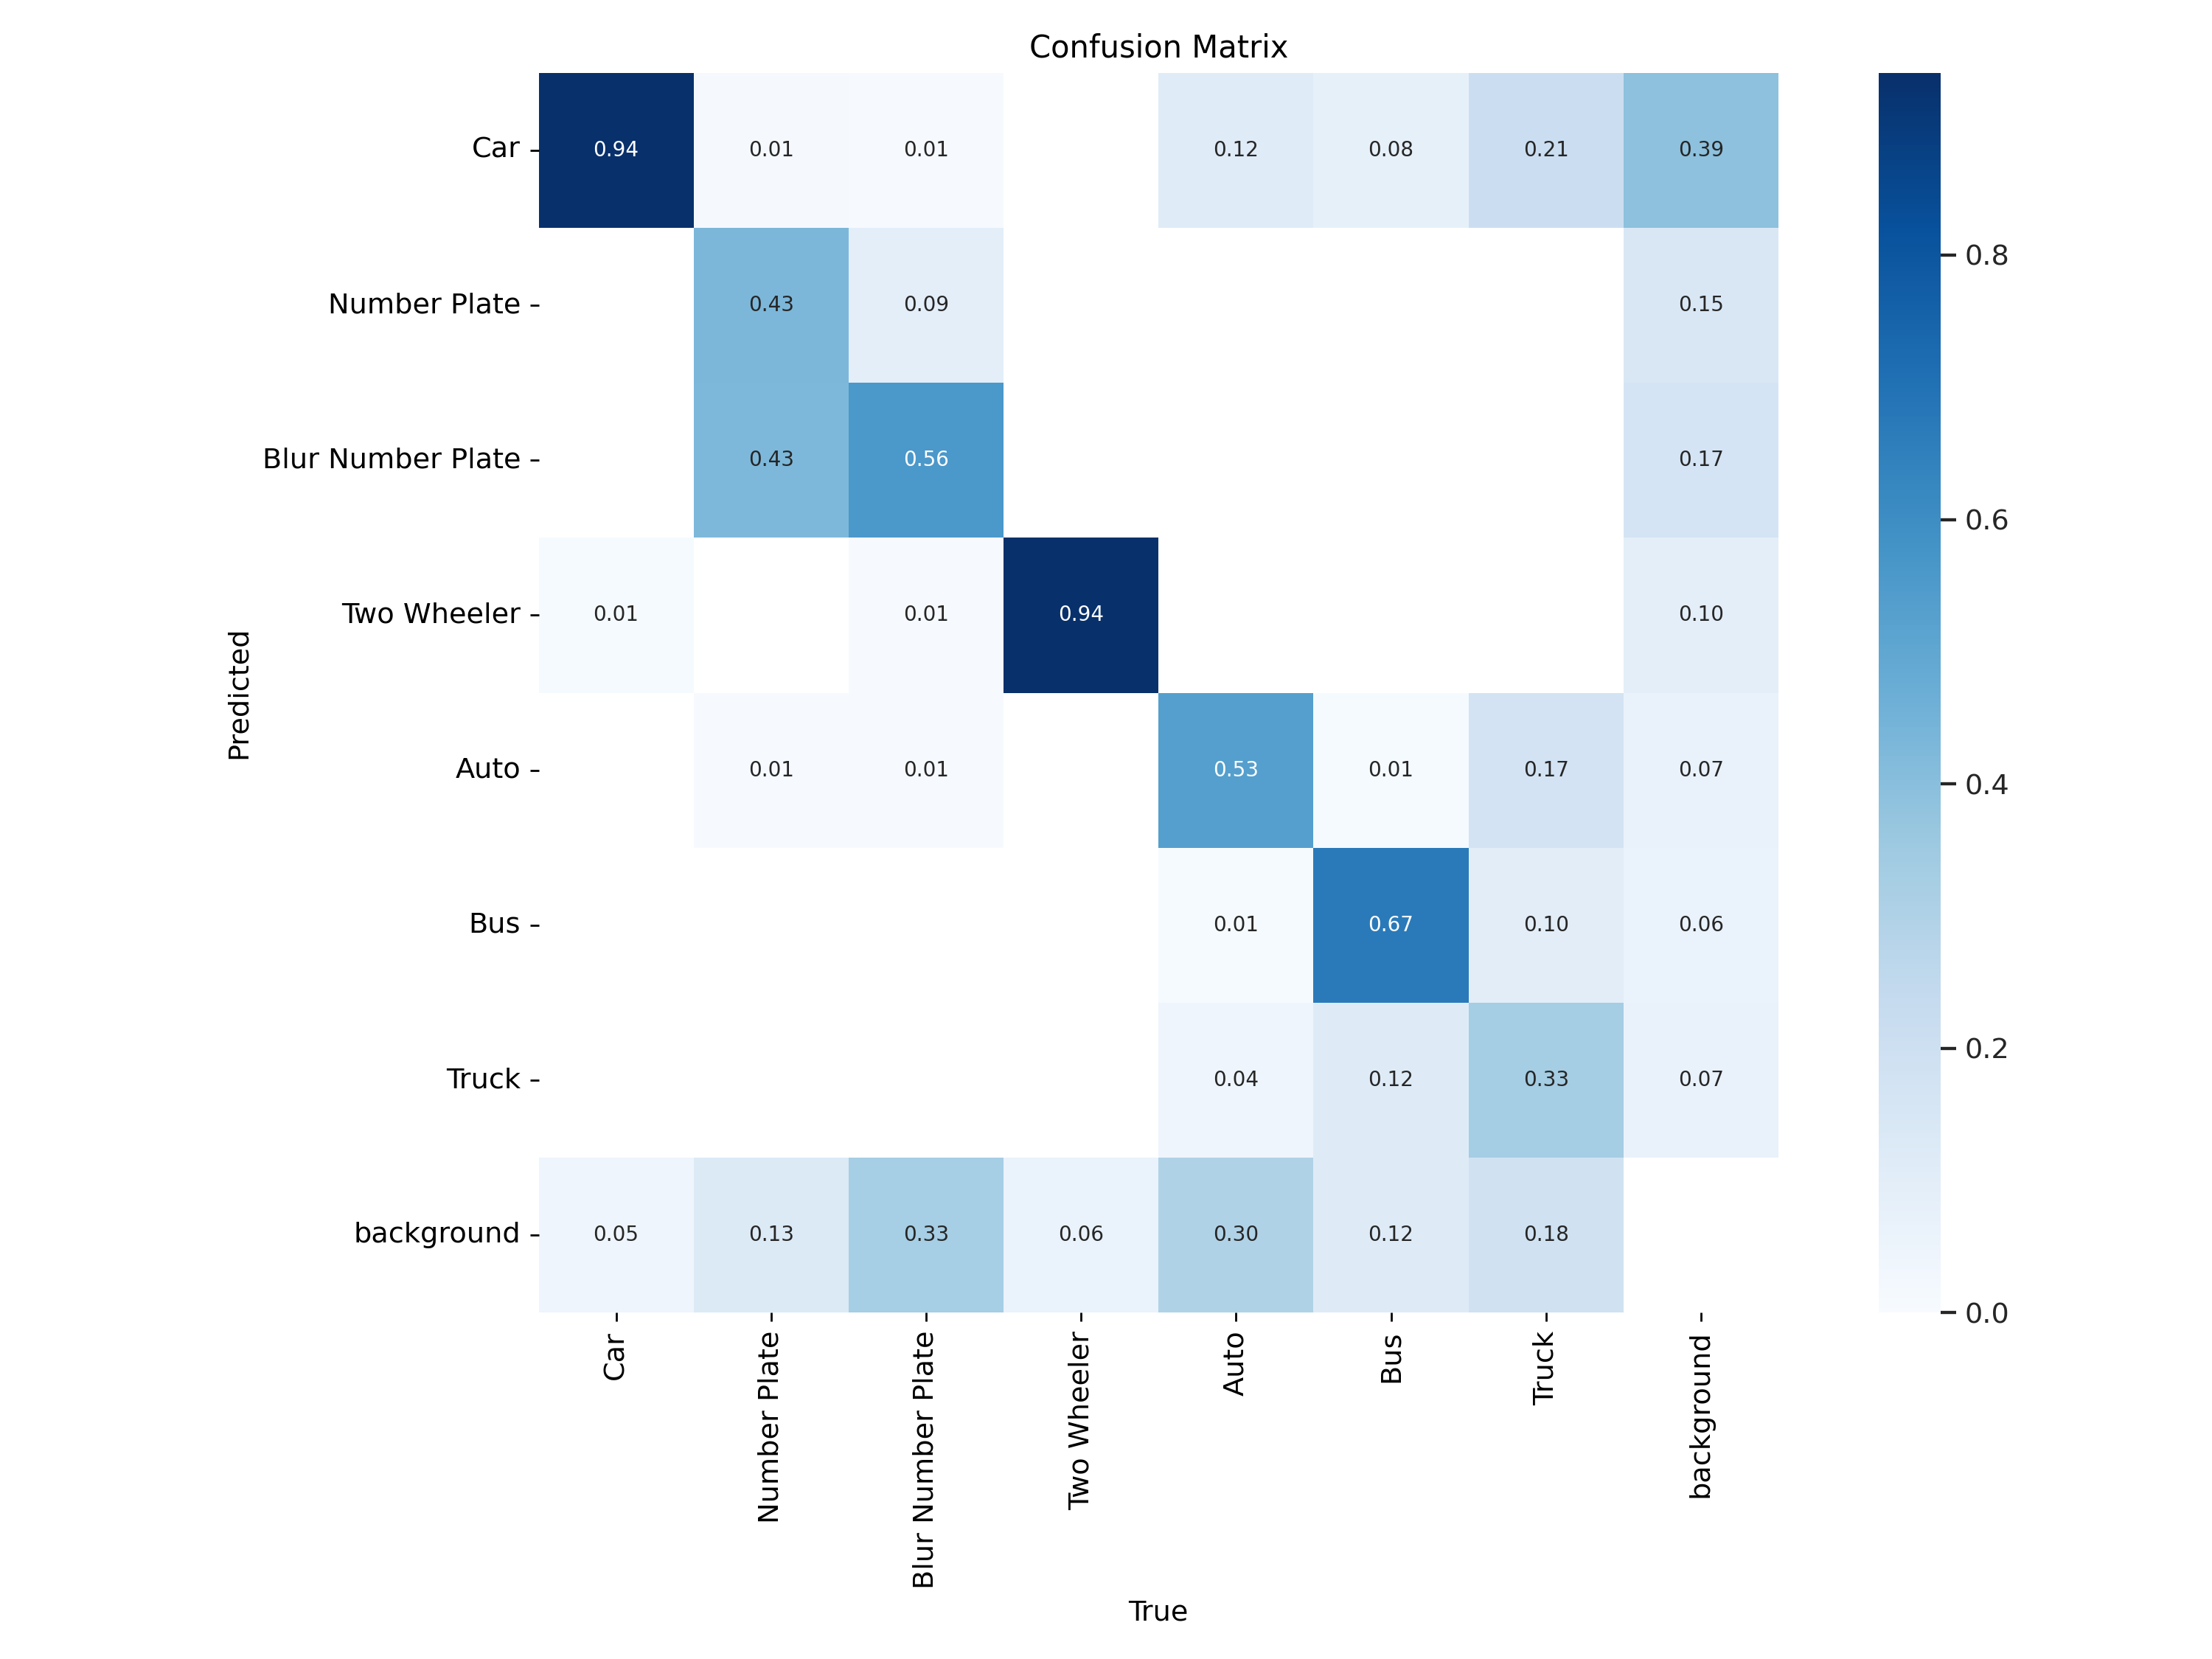

In [ ]:
val_result = Image(filename='runs/val/exp/confusion_matrix.png')
display(val_result)

In [ ]:
#load the trained model
model = torch.hub.load("./", "custom", path="./runs/train/exp/weights/best.pt", source="local")

YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


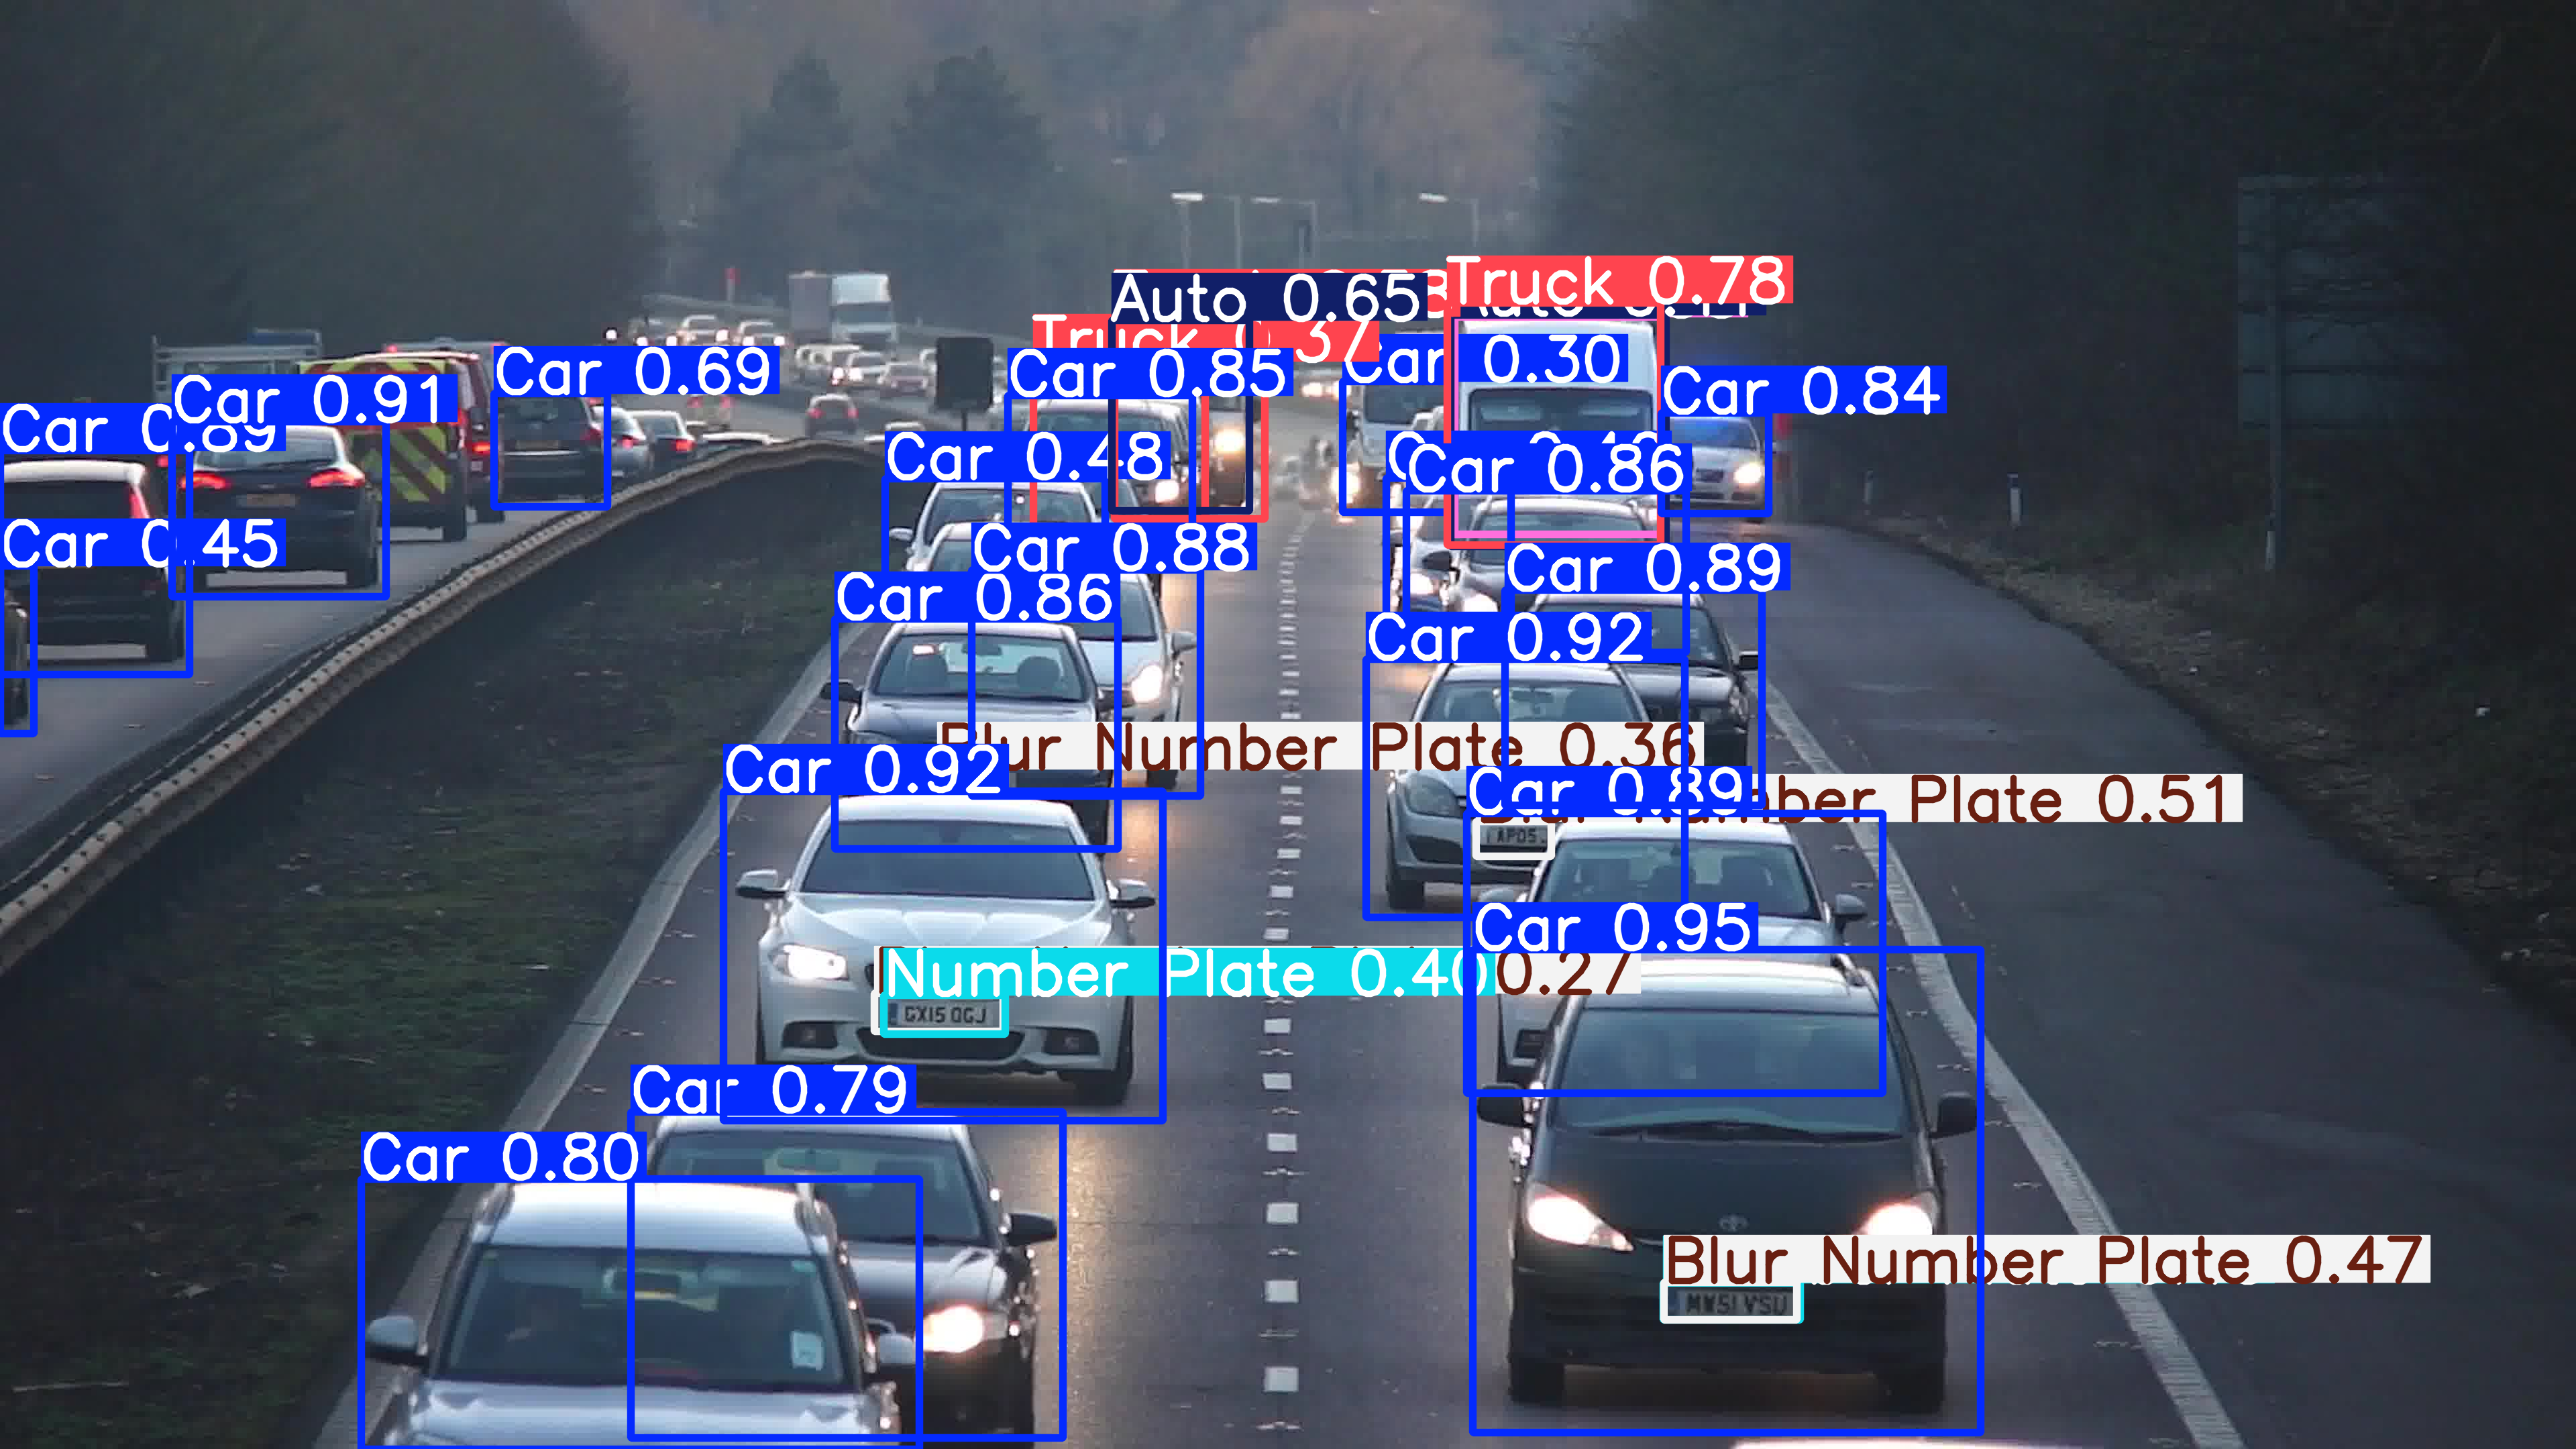

/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


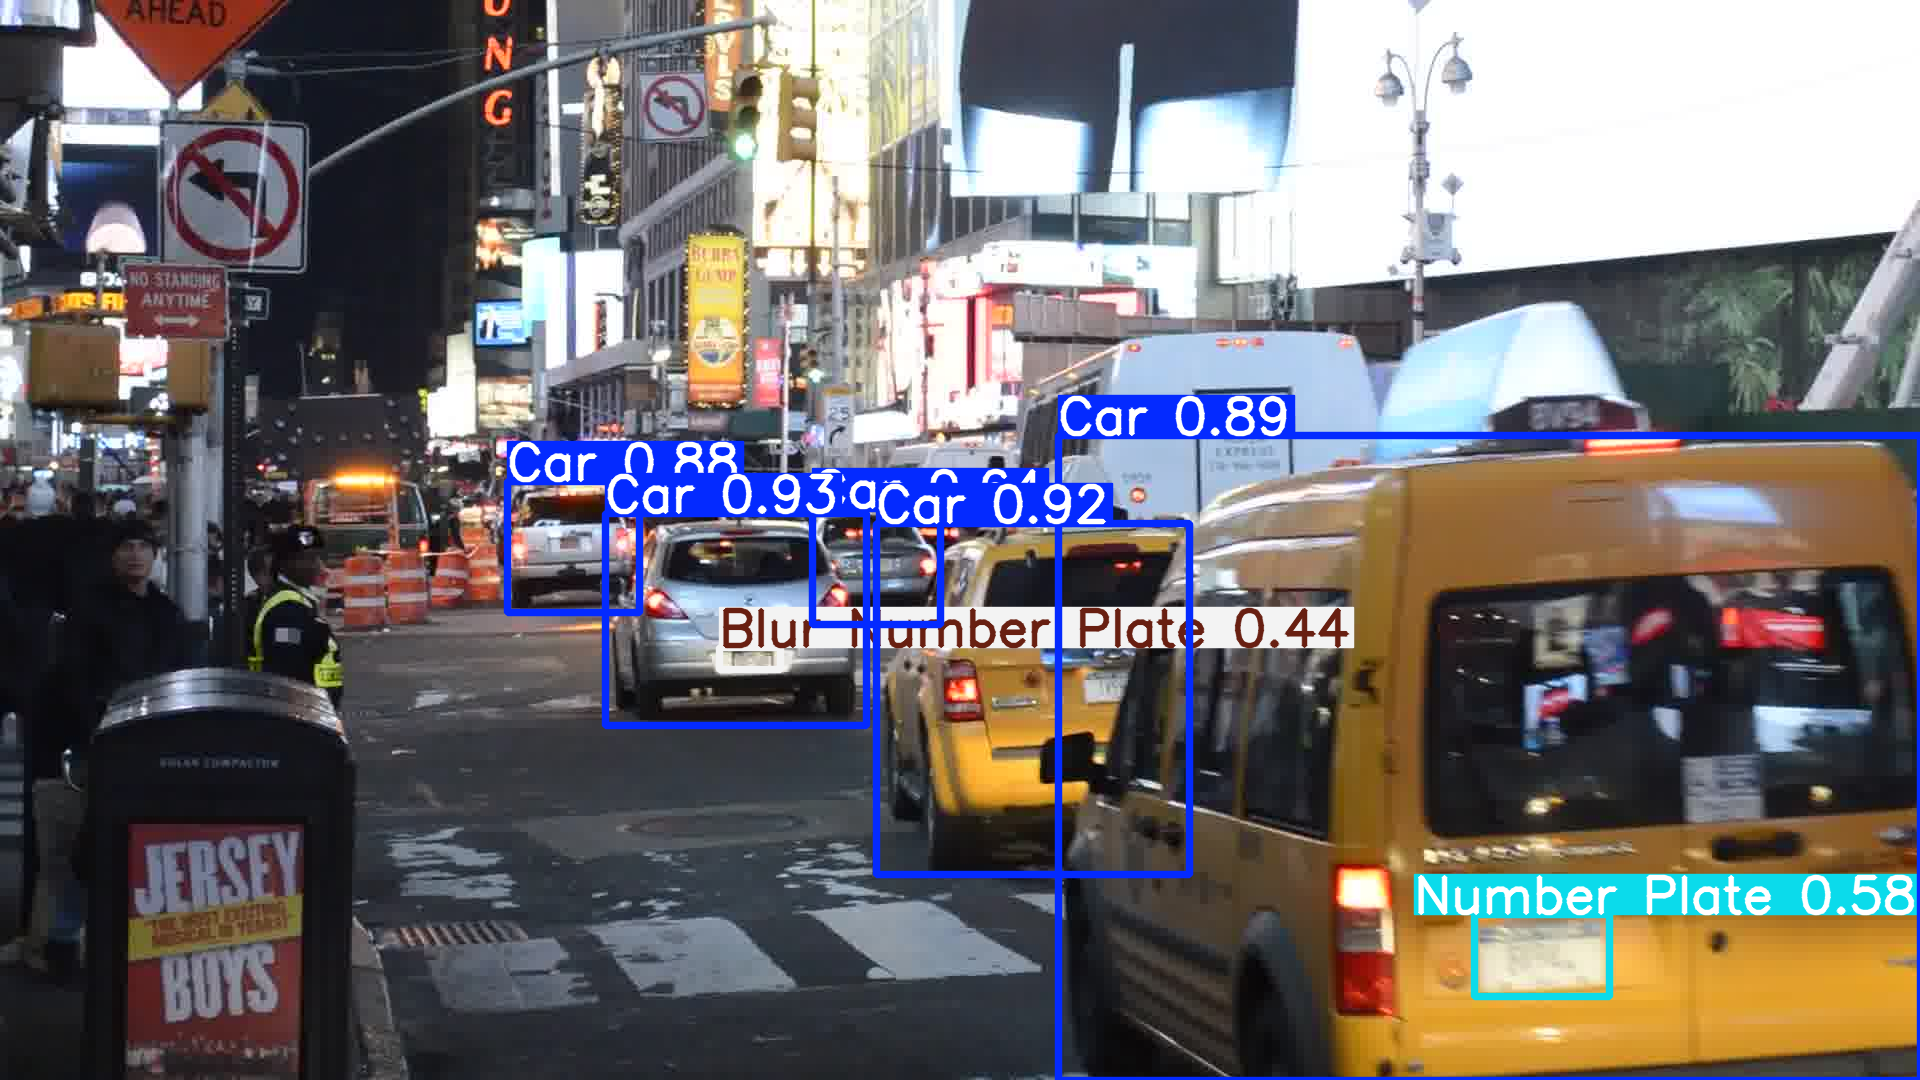

/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


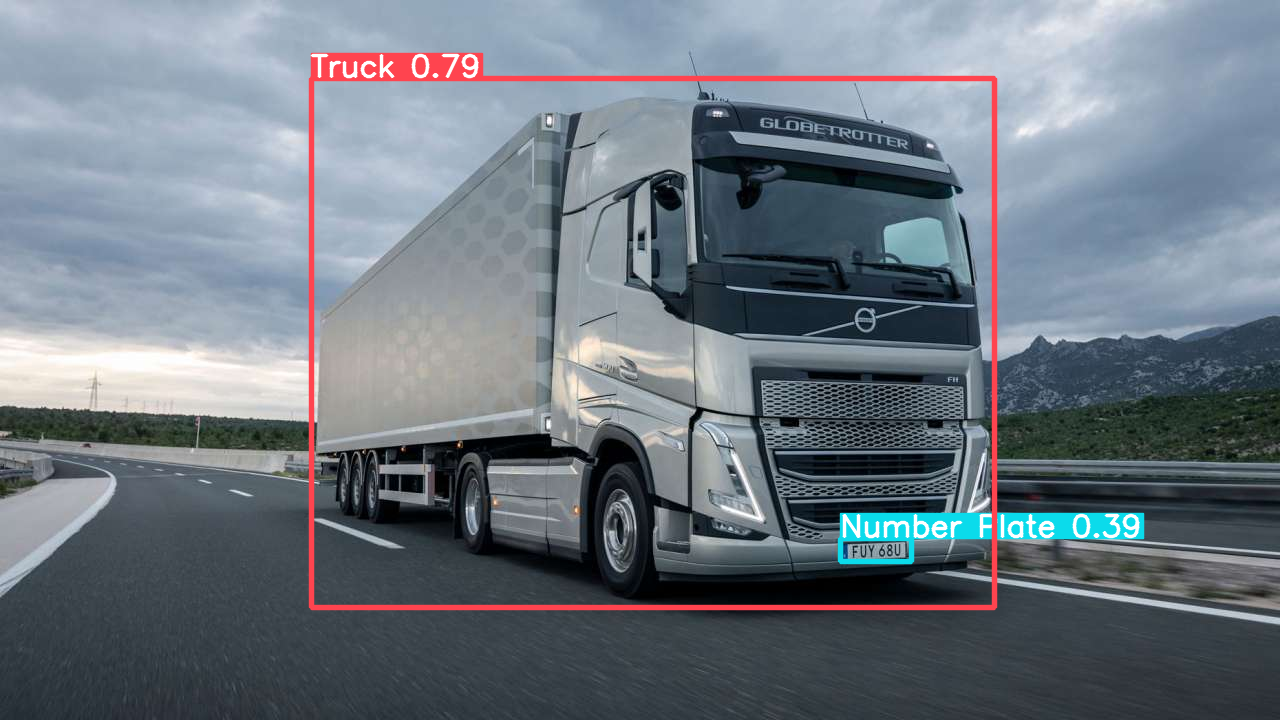

In [ ]:
#Testing on 3 examle
img_arr = [244, 175, 326]
for img in img_arr:
    img = f'/content/kaggle/Traffic Dataset/images/test/00 ({img}).jpg'
    results = model(img)
    results.show()

In [ ]:
#Video Testing
!python detect.py --weights ./runs/train/exp/weights/best.pt --source '../kaggle/Traffic Dataset/images/test/Video15.mp4' --project results --name output

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
detect: weights=['./runs/train/exp/weights/best.pt'], source=../kaggle/Traffic Dataset/images/test/Video15.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=results, name=output, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-388-g882c35fc Python-3.10.12 torch-2.5.1+cu121 CPU

Fusing layers... 
Model summary: 157 layers, 7029004 parameters, 0 gradients, 15.8 GFL

In [ ]:
#Traffic Analysis
video_path = "/content/kaggle/Traffic Dataset/images/test/Video15.mp4"
video = cv2.VideoCapture(video_path)

if not video.isOpened():
    print("Error opening video file")
else:
    frame_count = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if frame_count % 20 == 0:
          result = model(frame)
          detections = result.pandas().xyxy[0]
          vehicle_boxes = detections[detections['name'].isin(['Car', 'Two Wheeler', 'Auto', 'Bus', 'Truck'])]
          total_vehicle_area = 0
          total_vehicle = 0
          #Calculate the total area of all the vehicles
          for index, row in vehicle_boxes.iterrows():
            x1, y1, x2, y2 = row['xmin'], row['ymin'], row['xmax'], row['ymax']
            total_vehicle_area += (x2 - x1) * (y2 - y1)
            total_vehicle += 1
          #Calculate the street area (Subtract the sky and background)
          image_height, image_width, _ = frame.shape
          street_area = 596190 * 0.55
          threshold = 0.6
          if total_vehicle_area / street_area >= threshold:
            traffic_condition = "High"
          else:
            traffic_condition = "Normal"
          print(f"Frame: {frame_count} - Total vehicle: {total_vehicle} - Traffic Condition: {traffic_condition}")
        frame_count += 1

/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 0 - Total vehicle: 23 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 20 - Total vehicle: 22 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 40 - Total vehicle: 22 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 60 - Total vehicle: 21 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 80 - Total vehicle: 20 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 100 - Total vehicle: 21 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 120 - Total vehicle: 20 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 140 - Total vehicle: 20 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 160 - Total vehicle: 17 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 180 - Total vehicle: 17 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 200 - Total vehicle: 19 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 220 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 240 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 260 - Total vehicle: 17 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 280 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 300 - Total vehicle: 17 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 320 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 340 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 360 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 380 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 400 - Total vehicle: 18 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 420 - Total vehicle: 17 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 440 - Total vehicle: 15 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 460 - Total vehicle: 16 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 480 - Total vehicle: 15 - Traffic Condition: High


/content/yolov5/./models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


Frame: 500 - Total vehicle: 17 - Traffic Condition: High
